In [10]:
import mitsuba as mi
mi.set_variant("llvm_ad_rgb")
import drjit as dr

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np

import cmap_diff

## 1D elevation angle plots

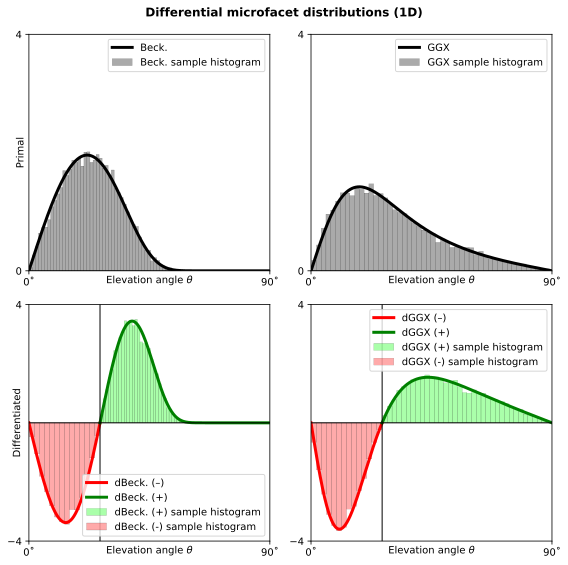

In [38]:
alpha = 0.5 # Surface roughness
vminmax = 4 # y-axis scale

N = 1000
U = 10000
np.random.seed(0)
u = np.random.uniform(size=(U,2))

theta_0 = dr.atan(alpha) # Zero-crossing

bins_total = 50
bins_neg   = int((2*theta_0 / np.pi) * bins_total)
bins_pos   = bins_total - bins_neg

def generate_vectors(start=0, end=dr.pi, N=N):
    theta = dr.linspace(mi.Float, start, end, N)
    cos_theta = dr.cos(theta)
    sin_theta = dr.safe_sqrt(1 - dr.cos(theta)**2)
    v = mi.Vector3f(sin_theta, 0, cos_theta)
    # Scale factor to turn the 2D hemispherical distr. into a 1D distr over spherical coordinate `theta`
    scale = 2*dr.pi*sin_theta
    return theta, v, scale

theta,     v,     scale     = generate_vectors(0, dr.pi/2)
theta_neg, v_neg, scale_neg = generate_vectors(0, theta_0)
theta_pos, v_pos, scale_pos = generate_vectors(theta_0, dr.pi/2)

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8,8))

# Evaluate Beckmann variants
f      =  mi.warp.square_to_beckmann_pdf(v, alpha) * scale
df_neg = -mi.diff_microfacet.square_to_d_beckmann_neg_pdf(v_neg, alpha) * scale_neg # Flip for plot
df_pos =  mi.diff_microfacet.square_to_d_beckmann_pos_pdf(v_pos, alpha) * scale_pos

# Sample Beckmann variants
m     = dr.acos(mi.warp.square_to_beckmann(u, alpha)[2])
m_neg = dr.acos(mi.diff_microfacet.square_to_d_beckmann_neg(u, alpha)[2])
m_pos = dr.acos(mi.diff_microfacet.square_to_d_beckmann_pos(u, alpha)[2])



ax[0, 0].hist(m, density=True, bins=bins_total,
              color='#00000055', edgecolor='k', lw=0.1, label='Beck. sample histogram')
ax[0, 0].plot(theta, f, lw=3, color='k', label='Beck.')
ax[0, 0].plot(theta, np.zeros(len(theta)), lw=1, color='k')

# "Negative histogram" workaround
heights, bins = np.histogram(m_neg, density=True, bins=bins_neg)
heights *= -1
bin_width = np.diff(bins)[0]
bin_pos = (bins[:-1] + bin_width / 2)
ax[1, 0].bar(bin_pos, heights, width=bin_width,
             color='#ff000055', edgecolor='k', lw=0.1, label='dBeck. (-) sample histogram')
ax[1, 0].hist(m_pos, density=True, bins=bins_pos,
              color='#00ff0055', edgecolor='k', lw=0.1, label='dBeck. (+) sample histogram')
ax[1, 0].plot(theta_neg, df_neg, lw=3, color='r', label='dBeck. (–)')
ax[1, 0].plot(theta_pos, df_pos, lw=3, color='g', label='dBeck. (+)')
ax[1, 0].plot([theta_0, theta_0], [-100, 100], lw=1, color='k')
ax[1, 0].plot(theta, np.zeros(len(theta)), lw=1, color='k')

# Evaluate GGX variants
f      =  mi.warp.square_to_ggx_pdf(v, alpha) * scale
df_neg = -mi.diff_microfacet.square_to_d_ggx_neg_pdf(v_neg, alpha) * scale_neg # Flip for plot
df_pos =  mi.diff_microfacet.square_to_d_ggx_pos_pdf(v_pos, alpha) * scale_pos

# Sample GGX variants
m     = dr.acos(mi.warp.square_to_ggx(u, alpha)[2])
m_neg = dr.acos(mi.diff_microfacet.square_to_d_ggx_neg(u, alpha)[2])
m_pos = dr.acos(mi.diff_microfacet.square_to_d_ggx_pos(u, alpha)[2])

ax[0, 1].hist(m, density=True, bins=bins_total,
              color='#00000055', edgecolor='k', lw=0.1, label='GGX sample histogram')
ax[0, 1].plot(theta, f, lw=3, color='k', label='GGX')
ax[0, 1].plot(theta, np.zeros(len(theta)), lw=1, color='k')

# "Negative histogram" workaround
heights, bins = np.histogram(m_neg, density=True, bins=bins_neg)
heights *= -1
bin_width = np.diff(bins)[0]
bin_pos = (bins[:-1] + bin_width / 2)
ax[1, 1].bar(bin_pos, heights, width=bin_width,
             color='#ff000055', edgecolor='k', lw=0.1, label='dGGX (-) sample histogram')
ax[1, 1].hist(m_pos, density=True, bins=bins_pos,
              color='#00ff0055', edgecolor='k', lw=0.1, label='dGGX (+) sample histogram')
ax[1, 1].plot(theta_neg, df_neg, lw=3, color='r', label='dGGX (–)')
ax[1, 1].plot(theta_pos, df_pos, lw=3, color='g', label='dGGX (+)')
ax[1, 1].plot([theta_0, theta_0], [-100, 100], lw=1, color='k')
ax[1, 1].plot(theta, np.zeros(len(theta)), lw=1, color='k')

for ax_ in ax.flatten():
    ax_.set_xlim([0, np.pi/2])
    ax_.set_xticks([0, np.pi/2])
    ax_.set_xticklabels(['0˚', '90˚'])
    ax_.set_xlabel(r'Elevation angle $\theta$', labelpad=-12)
    ax_.legend()
for ax_ in ax[0,:]:
    ax_.set_ylim([0, vminmax])
    ax_.set_yticks([0, vminmax])
for ax_ in ax[1,:]:
    ax_.set_ylim([-vminmax, vminmax])
    ax_.set_yticks([-vminmax, vminmax])
ax[0,0].set_ylabel('Primal', labelpad=-10)
ax[1,0].set_ylabel('Differentiated', labelpad=-15)

fig.suptitle("Differential microfacet distributions (1D)", weight='bold', y=0.98)

plt.tight_layout()
plt.show()


## 2D Projected disk plots

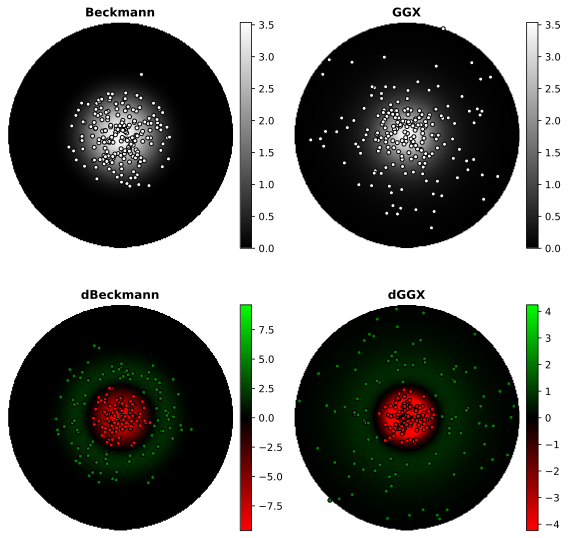

In [42]:
alpha = 0.3   # Surface roughness

np.random.seed(0)

def primal_distr(f_pdf, f_sample, RES=1000, U=200):
    # Setup vectors on hemisphere
    pos = dr.arange(mi.UInt32, RES*RES)
    pos = mi.Vector2f(mi.Float(pos %  int(RES)),
                      mi.Float(pos // int(RES))) * dr.rcp(mi.Vector2f(RES))
    x = 2*pos[0] - 1
    y = 2*pos[1] - 1
    z = dr.safe_sqrt(1 - x**2 - y**2)
    omega = mi.Vector3f(x,y,z)
    valid = (1 - x**2 - y**2 > 0.0).numpy().reshape(RES, RES)
    
    # Evaluate
    values = f_pdf(omega, alpha).numpy().reshape(RES, RES)
    vminmax = np.max(values)
    values[~valid] = np.nan
    
    # Sample
    u = np.random.uniform(size=(U, 2))
    m = f_sample(u, alpha)
    samples = [m[0], m[1]]
   
    return values, vminmax, samples


def diff_distr(f_pdf_neg, f_pdf_pos, f_sample_neg, f_sample_pos, RES=1000, U=200):
    # Setup vectors on hemisphere
    pos = dr.arange(mi.UInt32, RES*RES)
    pos = mi.Vector2f(mi.Float(pos %  int(RES)),
                      mi.Float(pos // int(RES))) * dr.rcp(mi.Vector2f(RES))
    x = 2*pos[0] - 1
    y = 2*pos[1] - 1
    z = dr.safe_sqrt(1 - x**2 - y**2)
    omega = mi.Vector3f(x,y,z)
    valid = (1 - x**2 - y**2 > 0.0).numpy().reshape(RES, RES)
    
    # Evaluate
    values_neg = f_pdf_neg(omega, alpha).numpy().reshape(RES, RES)
    values_pos = f_pdf_pos(omega, alpha).numpy().reshape(RES, RES)
    vmin = np.max(values_neg)
    vmax = np.max(values_pos)
    vminmax = np.maximum(vmin, vmax)

    values = values_pos - values_neg
    values[~valid] = np.nan
    
    # Sample
    u = np.random.uniform(size=(U//2, 2))
    m_neg = f_sample_neg(u, alpha)
    m_pos = f_sample_pos(u, alpha)
    samples_neg = [m_neg[0], m_neg[1]]
    samples_pos = [m_pos[0], m_pos[1]]
   
    return values, vminmax, samples_neg, samples_pos
    
    
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8,8))

# Beckmann variants
values, vminmax, samples = primal_distr(mi.warp.square_to_beckmann_pdf,
                                        mi.warp.square_to_beckmann)

im = ax[0, 0].imshow(values, cmap='gray', vmin=0, vmax=vminmax, extent=[-1, 1, -1, 1])
divider = make_axes_locatable(ax[0, 0]); cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
ax[0, 0].plot(samples[0], samples[1], 'o', color='w', ms=4, markeredgewidth=1, markeredgecolor='k')
ax[0, 0].set_title('Beckmann', weight='bold')

tmp = diff_distr(mi.diff_microfacet.square_to_d_beckmann_neg_pdf,
                 mi.diff_microfacet.square_to_d_beckmann_pos_pdf,
                 mi.diff_microfacet.square_to_d_beckmann_neg,
                 mi.diff_microfacet.square_to_d_beckmann_pos)
values, vminmax, samples_neg, samples_pos = tmp

im = ax[1, 0].imshow(values, cmap='diff', vmin=-vminmax, vmax=vminmax, extent=[-1, 1, -1, 1])
divider = make_axes_locatable(ax[1, 0]); cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
ax[1, 0].plot(samples_neg[0], samples_neg[1], 'o', color='r', ms=4, markeredgewidth=1, markeredgecolor='k')
ax[1, 0].plot(samples_pos[0], samples_pos[1], 'o', color='g', ms=4, markeredgewidth=1, markeredgecolor='k')
ax[1, 0].set_title('dBeckmann', weight='bold')


# GGX variants
values, vminmax, samples = primal_distr(mi.warp.square_to_ggx_pdf,
                                        mi.warp.square_to_ggx)

im = ax[0, 1].imshow(values, cmap='gray', vmin=0, vmax=vminmax, extent=[-1, 1, -1, 1])
divider = make_axes_locatable(ax[0, 1]); cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
ax[0, 1].set_title('GGX', weight='bold')
ax[0, 1].plot(samples[0], samples[1], 'o', color='w', ms=4, markeredgewidth=1, markeredgecolor='k')

tmp = diff_distr(mi.diff_microfacet.square_to_d_ggx_neg_pdf,
                 mi.diff_microfacet.square_to_d_ggx_pos_pdf,
                 mi.diff_microfacet.square_to_d_ggx_neg,
                 mi.diff_microfacet.square_to_d_ggx_pos)
values, vminmax, samples_neg, samples_pos = tmp
vminmax *= 0.3

im = ax[1, 1].imshow(values, cmap='diff', vmin=-vminmax, vmax=vminmax, extent=[-1, 1, -1, 1])
divider = make_axes_locatable(ax[1, 1]); cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
ax[1, 1].plot(samples_neg[0], samples_neg[1], 'o', color='r', ms=4, markeredgewidth=1, markeredgecolor='k')
ax[1, 1].plot(samples_pos[0], samples_pos[1], 'o', color='g', ms=4, markeredgewidth=1, markeredgecolor='k')
ax[1, 1].set_title('dGGX', weight='bold')


for ax_ in ax.flatten():
    ax_.axis('off')

plt.tight_layout()
plt.show()